In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

## load data & feature extraction

In [6]:
from trainCRF_NLTK import split_train_test_set
%timeit
(X_train, y_train), (X_test, y_test) = split_train_test_set()

'load_data' ((), {}) 3.05 sec


## train CRF
To see all possible CRF parameters check its docstring. Here we are useing `L-BFGS` training algorithm (it is default) with `Elastic Net (L1 + L2) regularization`.

In [9]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=10000, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 13.3 s, sys: 103 ms, total: 13.4 s
Wall time: 13.5 s


## Evaluation

There is much more O entities in data set, but we're more interested in other entities. To account for this we'll use `averaged F1 score` computed for all labels except for O. sklearn-crfsuite.metrics package provides some useful metrics for sequence classification task, including this one.

In [11]:
labels = list(crf.classes_)

In [12]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.9823440816779346

Inspect per-class results in more detail:

In [13]:
# group B and I results
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          I      0.660     0.450     0.535       220
          O      0.988     0.995     0.992     10427

avg / total      0.982     0.984     0.982     10647



## Hyperparameter Optimization
To improve quality try to select regularization parameters using randomized search and 3-fold cross-validation.

I takes quite a lot of CPU time and RAM (we're fitting a model 50 * 3 = 150 times), so grab a tea and be patient, or reduce n_iter in RandomizedSearchCV, or fit model only on a subset of training data.

In [14]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/yekun/Documents/ENV/anaconda3/envs/mlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/yekun/Documents/ENV/anaconda3/envs/mlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/yekun/Documents/ENV/anaconda3/envs/mlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/yekun/Documents/ENV/anaconda3/envs/mlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average

/Users/yekun/Documents/ENV/anaconda3/envs/mlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/yekun/Documents/ENV/anaconda3/envs/mlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/yekun/Documents/ENV/anaconda3/envs/mlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/yekun/Documents/ENV/anaconda3/envs/mlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average

CPU times: user 43.5 s, sys: 6.29 s, total: 49.8 s
Wall time: 1min 39s


best results:

In [15]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.40981700188997705, 'c2': 0.04256544997184721}
best CV score: 0.974351963632894
model size: 0.10M


## Check parameter space
A chart which shows which c1 and c2 values have RandomizedSearchCV checked. `Red color means better results`, blue means worse.

Dark blue => 0.9705, dark red => 0.9744


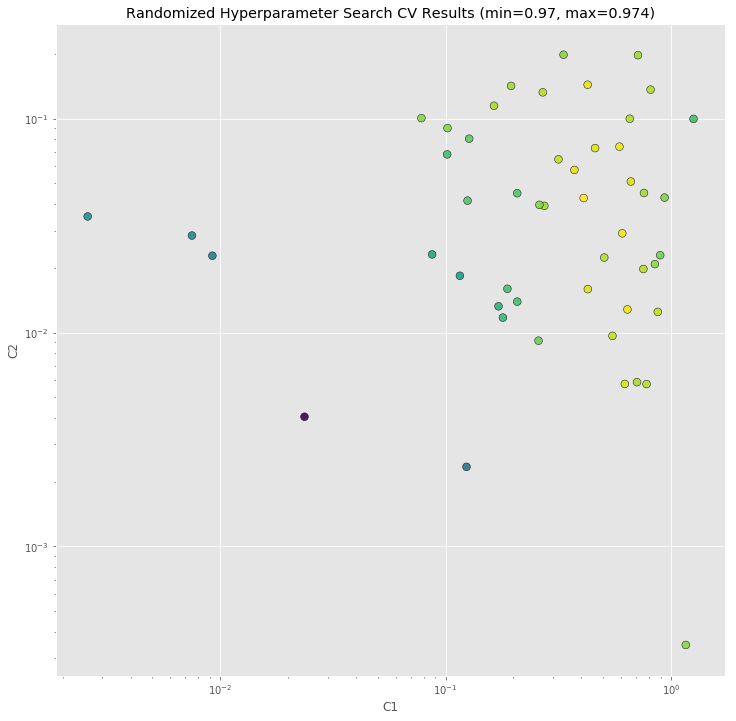

In [17]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

### Check best estimator on our test data¶

As you can see, quality is improved.

In [18]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          I      0.664     0.450     0.537       220
          O      0.988     0.995     0.992     10427

avg / total      0.982     0.984     0.982     10647



### Check what classifier learned

In [19]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
O      -> O       0.419940
O      -> I       0.041591
I      -> O       -0.210363
I      -> I       -3.581747

Top unlikely transitions:
O      -> O       0.419940
O      -> I       0.041591
I      -> O       -0.210363
I      -> I       -3.581747


In [20]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
5.945404 I        -1:word.lower=misinterpretation
5.030701 I        +1:word.lower=daniel
4.655765 I        +1:word.lower=chew
4.100111 I        +1:word.lower=duesh
4.028926 I        +1:word.lower=stfu
3.700717 I        word.lower=sab0tage
3.582049 I        +1:word.lower=sites
3.499383 I        +1:word.lower=cult
3.465893 I        -1:word.lower=meaning..
3.429954 I        word.lower=congradulations
3.325954 I        word.lower=derb
3.267477 I        -1:word.lower=plain
3.047616 I        -1:word.lower=exactly
2.959226 I        +1:word.lower=girlfriend
2.731848 I        word.lower=womo
2.677768 I        -1:word.lower=4
2.613511 I        +1:word.lower=satisfaction
2.449711 I        -1:word.lower=for
2.443837 I        +1:word.lower=expensive
2.429869 O        +1:word.lower=word
2.413420 I        +1:word.lower=fart
2.386819 I        +1:word.lower=mis-spelling
2.315625 I        +1:word.lower=infront
2.298190 I        -1:word.lower=say
2.297451 I        -1:word.lower=saying
2.288